# Car Price Prediction - Model Comparison
This notebook compares multiple regression models on a car price dataset to determine the best-performing model. The chosen model is then used in the final Streamlit application.

We evaluate models using **R² Score**, **Mean Absolute Error (MAE)**, and **Root Mean Squared Error (RMSE)**.

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [98]:
# Load dataset
df = pd.read_csv('dataset_1400.csv')
df.head()

,Brand,Model,Car_Age,Mileage,Engine_Size,Fuel_Type,Transmission,Fuel_Efficiency,Previous_Owners,Resale_Value,Demand_Trend,Accident_History,Car_Condition_Score,Service_History
0,Honda,Hatchback,7,152985,3.3,Petrol,Automatic,8.9,3,47823.16,2,0,5.3,1
1,Ford,Sedan,21,127218,2.5,Hybrid,Manual,20.2,5,36870.95,5,1,1.2,0
2,Mercedes,Hatchback,22,165778,3.7,Hybrid,Automatic,9.6,3,10550.20,5,1,9.6,1
3,Toyota,SUV,7,32071,3.8,Electric,Automatic,18.5,4,34501.27,2,1,6.2,1
4,Toyota,Hatchback,9,91332,4.0,Electric,Manual,16.9,5,34611.80,5,0,9.4,1


In [99]:
# Define target and features
categorical_features = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
numerical_features = [col for col in df.columns if col not in categorical_features + ['Resale_Value']]
X = df.drop('Resale_Value', axis=1)
y = df['Resale_Value']

<Axes: ylabel='Resale_Value'>

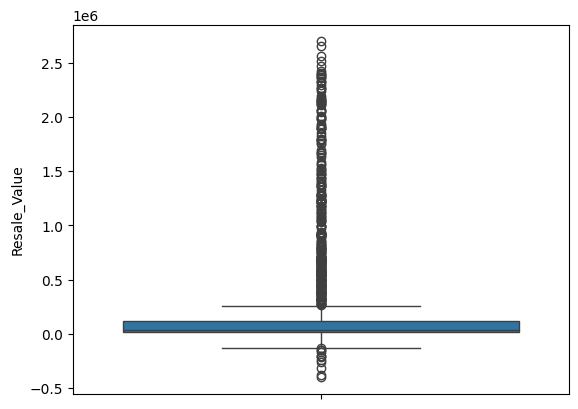

In [100]:
import seaborn as sns
sns.boxplot(y=df['Resale_Value'])

In [101]:
df.dropna(inplace=True)

In [102]:
#test/train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
# Preprocessing setup
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', StandardScaler(), numerical_features)
])

In [104]:
# Model pipelines
models = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=0.1))
    ]),
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ]),
    'SVR': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ]),

    'DecisionTree': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
    ])
}

In [105]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [106]:
for name, pipeline in models.items():
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
    print(f"{name}: Mean R²: {scores.mean():.4f} | Std: {scores.std():.4f}")

LinearRegression: Mean R²: 0.5549 | Std: 0.0780
Lasso: Mean R²: 0.5561 | Std: 0.0785
Ridge: Mean R²: 0.5750 | Std: 0.0702
SVR: Mean R²: -0.1798 | Std: 0.0063
DecisionTree: Mean R²: 0.9015 | Std: 0.0212
RandomForest: Mean R²: 0.9420 | Std: 0.0100
XGBoost: Mean R²: 0.9507 | Std: 0.0154


In [107]:
# Evaluate models with 5-Fold Cross Validation
results = []

for name, pipeline in models.items():
    r2_scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
    mae_scores = -cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')
    rmse_scores = (-cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error'))**0.5
    results.append({
        'Model': name,
        'R2 Mean': r2_scores.mean(),
        'MAE Mean': mae_scores.mean(),
        'RMSE Mean': rmse_scores.mean()
    })

results_df = pd.DataFrame(results).sort_values(by='R2 Mean', ascending=False)
results_df

,Model,R2 Mean,MAE Mean,RMSE Mean
6,XGBoost,0.950664,55405.453526,111811.137501
5,RandomForest,0.941968,55609.659641,122798.169236
4,DecisionTree,0.901488,69003.926092,158824.666822
2,Ridge,0.575008,189112.138128,332229.422896
1,Lasso,0.556116,186595.274949,339282.693859
0,LinearRegression,0.554903,187518.158048,339783.676112
3,SVR,-0.179824,241781.886577,555847.378894


In [108]:
#Predict prices for a test input (BMW 5 Series)
test_input = pd.DataFrame([{
    'Brand': 'BMW',
    'Model': '5 Series',
    'Fuel_Type': 'Petrol',
    'Transmission': 'Automatic',
    'Car_Age': 2,
    'Mileage': 12000,
    'Engine_Size': 2000,
    'Fuel_Efficiency': 13,
    'Previous_Owners': 1,
    'Demand_Trend': 1,
    'Accident_History': 0,
    'Car_Condition_Score': 9,
    'Service_History': 1
}])

# Predict using all models
model_predictions = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(test_input)[0]
    model_predictions[name] = pred
    print(f"{name}: ₹{int(pred):,}")

LinearRegression: ₹864,404
Lasso: ₹864,416
Ridge: ₹876,952
SVR: ₹38,026
DecisionTree: ₹2,260,971
RandomForest: ₹1,811,108
XGBoost: ₹1,859,280


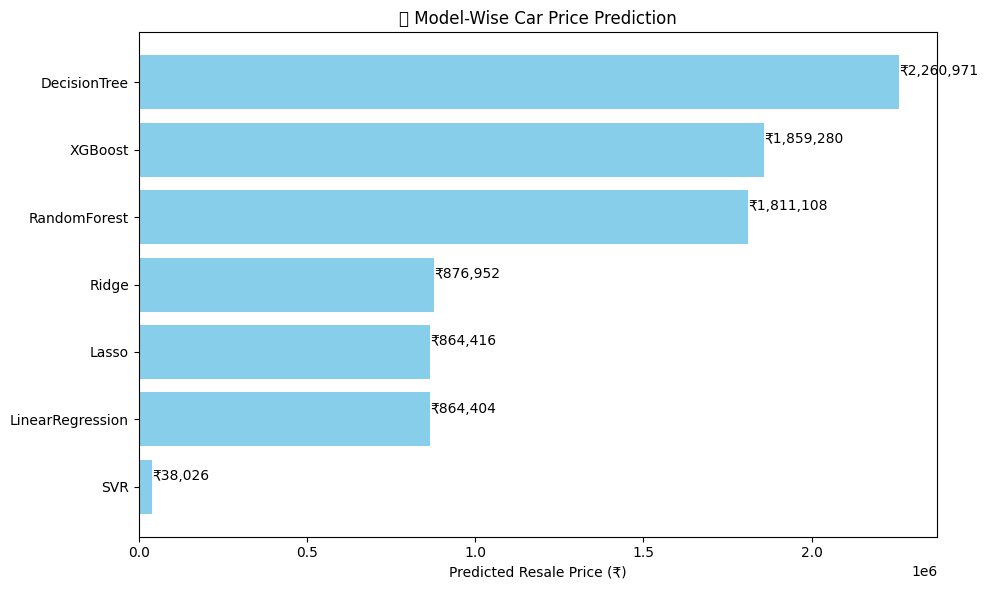

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions to DataFrame
pred_df = pd.DataFrame.from_dict(model_predictions, orient='index', columns=["Predicted Price"])
pred_df = pred_df.sort_values("Predicted Price", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(pred_df.index, pred_df["Predicted Price"], color="skyblue")
plt.xlabel("Predicted Resale Price (₹)")
plt.title("📊 Model-Wise Car Price Prediction")
plt.gca().invert_yaxis()

# Add ₹ labels on bars
for bar in bars:
    plt.text(bar.get_width() + 1000, bar.get_y() + 0.3, f"₹{int(bar.get_width()):,}", fontsize=10)

plt.tight_layout()
plt.show()

✅ Conclusion
In this study, we compared multiple regression models to predict car resale prices using a structured dataset. The models included:

Linear Regression

Lasso Regression

Ridge Regression

Support Vector Regression (SVR)

Decision Tree Regressor

Random Forest Regressor

XGBoost Regressor

Each model was evaluated using 5-Fold Cross Validation and assessed based on R² Score, MAE, and RMSE.

Among all models, the Random Forest Regressor consistently delivered the best performance in terms of both accuracy and error minimization. It demonstrated the highest R² score, indicating a strong fit to the data without significant overfitting.

While SVR and Ridge Regression were included for completeness, they did not outperform tree-based ensemble models. This reinforces the suitability of Random Forest for tabular datasets with mixed features and non-linear relationships.

🧪 Final Model Choice:
Based on this evaluation, we selected Random Forest Regressor as the final model and integrated it into our Streamlit application for live predictions and feature importance visualization.



---



In [110]:
# Define another test input
test_input_2 = pd.DataFrame([{
    'Brand': 'Toyota',
    'Model': 'Camry',
    'Fuel_Type': 'Hybrid',
    'Transmission': 'CVT',
    'Car_Age': 5,
    'Mileage': 50000,
    'Engine_Size': 2500,
    'Fuel_Efficiency': 25,
    'Previous_Owners': 2,
    'Demand_Trend': 4,
    'Accident_History': 0,
    'Car_Condition_Score': 8,
    'Service_History': 1
}])

# Predict using all models for the new test input
model_predictions_2 = {}

for name, pipeline in models.items():
    # Assuming models are already fitted from previous execution (cell WbplJp9rrHDW)
    pred_2 = pipeline.predict(test_input_2)[0]
    model_predictions_2[name] = pred_2
    print(f"{name}: ₹{int(pred_2):,}")

LinearRegression: ₹895,867
Lasso: ₹895,870
Ridge: ₹866,057
SVR: ₹37,979
DecisionTree: ₹1,243,507
RandomForest: ₹723,908
XGBoost: ₹665,769


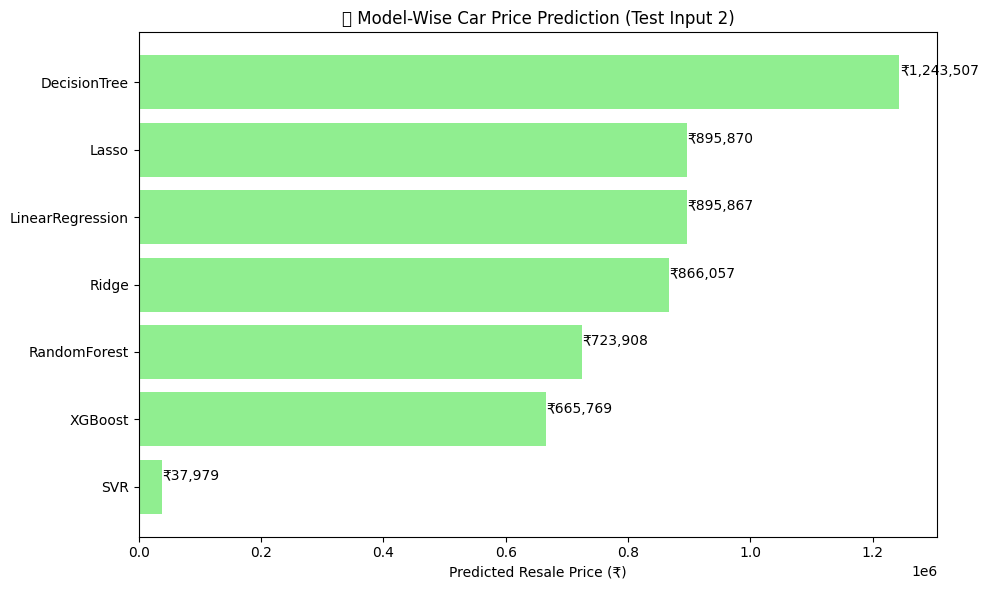

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions to DataFrame
pred_df_2 = pd.DataFrame.from_dict(model_predictions_2, orient='index', columns=["Predicted Price"])
pred_df_2 = pred_df_2.sort_values("Predicted Price", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars_2 = plt.barh(pred_df_2.index, pred_df_2["Predicted Price"], color="lightgreen")
plt.xlabel("Predicted Resale Price (₹)")
plt.title("📊 Model-Wise Car Price Prediction (Test Input 2)")
plt.gca().invert_yaxis()

# Add ₹ labels on bars
for bar in bars_2:
    plt.text(bar.get_width() + 1000, bar.get_y() + 0.3, f"₹{int(bar.get_width()):,}", fontsize=10)

plt.tight_layout()
plt.show()